##### Inicio

#### Carga de datos

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import sklearn
import logging
import warnings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

#  cargar algoritmos para aprendizaje supervisado
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, mutual_info_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

# importar fichero con utilidades propias
from commons import myfunctions as myfunc


CPU_COUNT: 24; NODE: amilcar32; sys.version: 3.10.12 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 19:09:20) [MSC v.1916 64 bit (AMD64)]
LOKY_MAX_CPU_COUNT is not set.
OMP_NUM_THREADS is not set.


#### Parámetros a utilizar en el entrenamiento.

Se indican los 3 algoritmos de *selección de características* (eval_selector_xxx) y los 3 algoritmos para la _clasificación_ (eval_clasifier_xxx)

En *param_distributions* se indicar los parámetros que utilizan los algoritmos en la función RandomSearchCV.

Esta celda tiene la etiqueta **parameters** que servirá para poder lanzar los entrenamientos con la utilidad **papermill** pasándole un fichero con los parámetros. Los nuevos parámetros se situarán tras esta celda para tener prevalencia.

In [2]:
#  Parametros para el entrenamiento

SEMILLA=        42
M_TIPO=         "mul_m"
M_SELECT=       "MI"
M_CLASIF=       "SVM"
R_FICHERO=      "resultados"
M_FICHERO=      "metricas"
PRE_DATA_FILE=  "rows_transpose_norm_by_gene_id_with_target_num_"
SCORING=        "roc_auc_ovr" 
MAX_ITERS=      100

def mutual_info_classif_state(X, y):
    return mutual_info_classif(X, y, random_state=SEMILLA)

eval_selector_mi = "SelectKBest(score_func=mutual_info_classif_state)"
eval_selector_rf=  "SelectFromModel(estimator=RandomForestClassifier(random_state=SEMILLA), threshold=-np.inf)"
eval_selector_anova=  "SelectKBest(score_func=f_classif)"

eval_clasifier_svm= "SVC(probability=True, random_state=SEMILLA)"
eval_clasifier_rf= "RandomForestClassifier(random_state=SEMILLA)"
eval_clasifier_lr= "LogisticRegressionCV(random_state=SEMILLA)"

if M_TIPO.startswith("bin_m"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_mi
    eval_clasifier = eval_clasifier_svm

    SEMILLA = 6578
    M_SELECT = "MI"
    M_CLASIF = "SVM"
    param_distributions = {'selector__k': [1000], 
         'clasifier__kernel': ['rbf'], 'clasifier__gamma': [0.01], 'clasifier__C': [100]}
elif M_TIPO.startswith("bin_s"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_rf
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 6191
    M_SELECT = "RF"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__max_features': [1000], 'selector__estimator__n_estimators': [200], 
        'clasifier__solver': ['lbfgs'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}

elif M_TIPO.startswith("mul_m"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
 
    eval_selector = eval_selector_rf
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 6191
    M_SELECT = "RF"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__max_features': [1000], 'selector__estimator__n_estimators': [400], 
        'clasifier__solver': ['lbfgs'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}

else:
    # M_TIPO.startswith("mul_s"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_anova
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 1860
    M_SELECT = "ANOVA"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__k': [1000], 
        'clasifier__solver': ['saga'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}



20231030T135425 : amilcar32 : INFO : Utilizando parámetros de mul_m


In [3]:
# Parameters
M_TIPO = "bin_m"
M_SELECT = "ANOVA"
M_CLASIF = "LR_L2"
P_FICHERO = "param_0000_6578_bin_m_ANOVA_LR_L2.yaml"
R_FICHERO = "resultados_6578"
M_FICHERO = "metricas_6578"
PRE_DATA_FILE = "rows_transpose_norm_by_gene_id_with_target_num_"
SCORING = "roc_auc_ovr"
SEMILLA = 6578
MAX_ITERS = 500
eval_selector = "SelectKBest(score_func=f_classif)"
eval_clasifier = "LogisticRegressionCV(random_state=SEMILLA)"
param_distributions = {
    "selector__k": [500],
    "clasifier__solver": ["lbfgs"],
    "clasifier__penalty": ["l2"],
    "clasifier__max_iter": [10000],
}


In [4]:
DATA_FILE = PRE_DATA_FILE + M_TIPO

# si viene "None" en el parámetro max_depth, se le quitan las comillas para que no sea entendido por el algoritmo como un texto
if "clasifier__max_depth" in param_distributions:
    param_distributions['clasifier__max_depth'] = [None if x == 'None' else x for x in param_distributions['clasifier__max_depth']]

Asignar los algoritmos que se utilizarán en la función RandomSearchCV

In [5]:
algor_selector=eval(eval_selector)
algor_clasifier=eval(eval_clasifier)

#### Comprobar el entorno y leer fichero de muestras

In [6]:
start_time = datetime.datetime.now()

myfunc.reset_vars()

myfunc.NOTEBK_FILENAME = myfunc.get_nb_name()

myfunc.check_enviroment(myfunc.DATA_DIR, myfunc.CFDNA_DIR, myfunc.GENCODE_DIR, myfunc.H5_DIR, myfunc.LOG_DIR, myfunc.CSV_DIR, myfunc.MODEL_DIR, myfunc.EXEC_DIR, myfunc.MET_DIR)

# Leer fichero con las muestras
df_t = myfunc.read_h5_to_df(DATA_FILE, myfunc.H5_DIR)
display(df_t.groupby("target").size())
print("Shape df:",df_t.shape)

# Separar caracteristicas/genes de las etiquetas/tipos de cáncer
X = df_t.iloc[:, :-1]  # Todas las columnas excepto la última
y = df_t.iloc[:, -1]  # La última columna contiene los identificadores de los tipos de cáncer

#  Crear el conjunto de datos de entrenamiento y de pruebas, y se fija la semilla para siempre coger el mismo juego de muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print("Shape X_train:",X_train.shape)
print("Shape X_test:",X_test.shape)


20231030T135425 : amilcar32 : INFO : Encontrada carpeta DATA_DIR=..\tfm_viu\datos
20231030T135425 : amilcar32 : INFO : Encontrada carpeta CFDNA_DIR=..\tfm_viu\datos\cfDNA_5hmC
20231030T135425 : amilcar32 : INFO : Encontrada carpeta GENCODE_DIR=..\tfm_viu\datos\gencode
20231030T135425 : amilcar32 : INFO : Encontrada carpeta H5_DIR=..\tfm_viu\datos\h5
20231030T135425 : amilcar32 : INFO : Encontrada carpeta LOG_DIR=..\tfm_viu\datos\logs
20231030T135425 : amilcar32 : INFO : Encontrada carpeta CSV_DIR=..\tfm_viu\datos\csv
20231030T135425 : amilcar32 : INFO : Encontrada carpeta MODEL_DIR=..\tfm_viu\ejecuciones\modelos
20231030T135425 : amilcar32 : INFO : Encontrada carpeta EXEC_DIR=..\tfm_viu\ejecuciones
20231030T135425 : amilcar32 : INFO : Encontrada carpeta MET_DIR=..\tfm_viu\ejecuciones\metricas
20231030T135425 : amilcar32 : INFO : Inicio leer fichero h5 ..\tfm_viu\datos\h5\rows_transpose_norm_by_gene_id_with_target_num_bin_m.h5
20231030T135425 : amilcar32 : INFO : Leyendo clave /df


20231030T135425 : amilcar32 : INFO : Tamaño (720, 18876)
20231030T135425 : amilcar32 : INFO : Fin leer fichero h5 ..\tfm_viu\datos\h5\rows_transpose_norm_by_gene_id_with_target_num_bin_m.h5


target
0    360
1    360
dtype: int64

Shape df: (720, 18876)


Shape X_train: (576, 18875)
Shape X_test: (144, 18875)


#### Selección de características y clasificación.

In [7]:
myfunc.verbose("Iniciando entrenamiento")

kf = KFold(n_splits=5, shuffle=True, random_state=SEMILLA)

# Crear el pipeline para el flujo de tareas
tasks_pipeline = Pipeline([
    ('selector', algor_selector),
    ('clasifier', algor_clasifier)
])

# MAX_ITERS puede limitar el número de iteraciones si son excesivas para las combinaciones de parámetros buscando un óptimo local, 
# sino funcionaría como GridSearchCV al revisar todas las cominaciones de los parámetros
num_iteraciones = 1
num_iteraciones = num_iteraciones * np.prod([len(elemento1) for _, elemento1 in param_distributions.items()])
max_iteraciones = num_iteraciones if num_iteraciones <= MAX_ITERS else MAX_ITERS
print("num_iter:",num_iteraciones,", max_iter:",max_iteraciones)

random_search = RandomizedSearchCV(
    tasks_pipeline, 
    param_distributions, 
    n_iter=max_iteraciones,
    scoring=SCORING,
    cv=kf,
    verbose=3, 
    random_state=SEMILLA, 
    n_jobs=-1
    )

# Entrenar el modelo
random_search.fit(X_train, y_train)

# Ver los mejores hiperparámetros encontrados
print(f'Mejores Hiperparámetros: {random_search.best_params_}')
print(f'Mejor Puntuación: {random_search.best_score_:.4f}')

# Nos quedamos con el mejor modelo para ver las métricas
mejor_modelo = random_search.best_estimator_

myfunc.verbose("Fin entrenamiento")

20231030T135425 : amilcar32 : INFO : Iniciando entrenamiento
num_iter: 1 , max_iter: 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\viu\miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 2265  2266  2803  2896  5803  8513  9490 11943 12831 13836 13848 15183
 15515 15824 16268 16287 16313 16323 16679 16870 16906 17024 17231 18530] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\viu\miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Mejores Hiperparámetros: {'selector__k': 500, 'clasifier__solver': 'lbfgs', 'clasifier__penalty': 'l2', 'clasifier__max_iter': 10000}
Mejor Puntuación: 0.8847
20231030T135430 : amilcar32 : INFO : Fin entrenamiento


#### Guardar modelo

In [8]:
fichero_modelo = str.replace("modelo_"+str(SEMILLA).zfill(4)+"_"+M_TIPO+"_"+M_SELECT+"_"+M_CLASIF+".pkl", " ", "_")

myfunc.save_modelo(mejor_modelo, myfunc.MODEL_DIR, fichero_modelo)

20231030T135430 : amilcar32 : INFO : Inicio guardar fichero ..\tfm_viu\ejecuciones\modelos\modelo_6578_bin_m_ANOVA_LR_L2.pkl
20231030T135430 : amilcar32 : INFO : Fin guardar fichero ..\tfm_viu\ejecuciones\modelos\modelo_6578_bin_m_ANOVA_LR_L2.pkl


#### Ver resultados del las iteraciones hechas por RandomSearchCV

In [9]:
myfunc.ver_resultados_search(random_search)

20231030T135430 : amilcar32 : INFO : Inicio ver resultados
Mejores Hiperparámetros: {'selector__k': 500, 'clasifier__solver': 'lbfgs', 'clasifier__penalty': 'l2', 'clasifier__max_iter': 10000}
Mejores puntuaciones: 0.8847 | Params: {'selector__k': 500, 'clasifier__solver': 'lbfgs', 'clasifier__penalty': 'l2', 'clasifier__max_iter': 10000}
Media de las puntuaciones: 0.8847 | Params: {'selector__k': 500, 'clasifier__solver': 'lbfgs', 'clasifier__penalty': 'l2', 'clasifier__max_iter': 10000}
20231030T135430 : amilcar32 : INFO : Fin resultados


#### Ver métricas del mejor modelo

20231030T135430 : amilcar32 : INFO : Inicio ver métricas


              precision    recall  f1-score   support

           0       0.88      0.88      0.88        82
           1       0.84      0.84      0.84        62

    accuracy                           0.86       144
   macro avg       0.86      0.86      0.86       144
weighted avg       0.86      0.86      0.86       144



   Exactitud: 0.8611
   Precisión: 0.8584
Sensibilidad: 0.8584
    F1-score: 0.8584
     AUC ROC: 0.9146


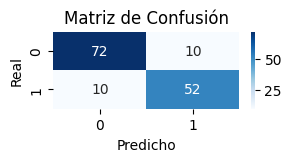

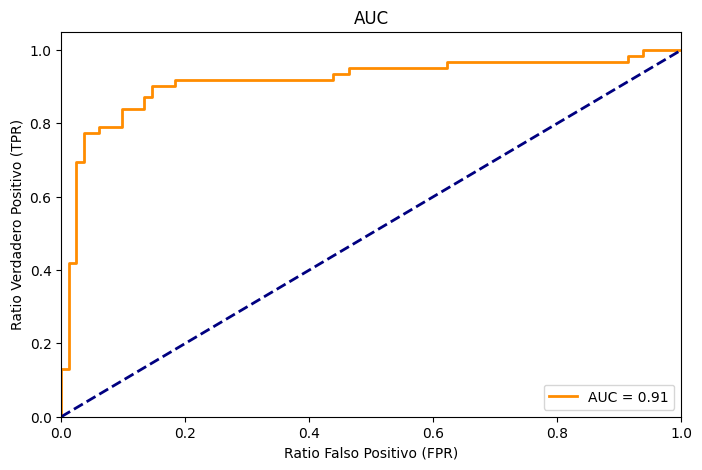

20231030T135430 : amilcar32 : INFO : Fin ver métricas


In [10]:
if M_TIPO.startswith("bin"):
    myfunc.ver_metricas(mejor_modelo, X_test, y_test)
else:
    myfunc.ver_metricas_multi(mejor_modelo, X_test, y_test)


#### Finalización del notebook

In [11]:
end_time = datetime.datetime.now()
total_time = end_time - start_time
myfunc.verbose(f"Notebook ha tardado {total_time.seconds} seconds")

20231030T135430 : amilcar32 : INFO : Notebook ha tardado 5 seconds


#### Guardar métricas

In [12]:
if M_TIPO.startswith("bin"):
    myfunc.save_metricas_to_csv(random_search, X_test, y_test, M_TIPO, M_SELECT, M_CLASIF, total_time, SEMILLA, myfunc.MET_DIR, M_FICHERO, fichero_modelo)
else:
    myfunc.save_metricas_multi_to_csv(random_search, X_test, y_test, M_TIPO, M_SELECT, M_CLASIF, total_time, SEMILLA, myfunc.MET_DIR, M_FICHERO, fichero_modelo)

df1=myfunc.read_metricas_to_df(myfunc.MET_DIR,M_FICHERO)

display(df1.sort_values("datetime", ascending=False)[:3])


20231030T135431 : amilcar32 : INFO : Inicio guardar métricas
20231030T135431 : amilcar32 : INFO : Inicio leer fichero ..\tfm_viu\ejecuciones\metricas\metricas_6578.csv
20231030T135431 : amilcar32 : INFO : Fin leer fichero ..\tfm_viu\ejecuciones\metricas\metricas_6578.csv


20231030T135431 : amilcar32 : INFO : Inicio guardar fichero ..\tfm_viu\ejecuciones\metricas\metricas_6578.csv
20231030T135431 : amilcar32 : INFO : Fichero borrado ..\tfm_viu\ejecuciones\metricas\metricas_6578.csv
20231030T135431 : amilcar32 : INFO : Fin guardar fichero ..\tfm_viu\ejecuciones\metricas\metricas_6578.csv
20231030T135431 : amilcar32 : INFO : Fin guardar métricas
20231030T135431 : amilcar32 : INFO : Inicio leer fichero ..\tfm_viu\ejecuciones\metricas\metricas_6578.csv
20231030T135431 : amilcar32 : INFO : Fin leer fichero ..\tfm_viu\ejecuciones\metricas\metricas_6578.csv


,tipo,select,clasific,semilla,accuracy,precision,recall,f1_score,roc_auc,hostname,total_time_sec,datetime,fichero_modelo,params,shape,features
0,bin_m,ANOVA,LR_L2,6578,0.861111,0.858379,0.858379,0.858379,0.914634,amilcar32,5,2023-10-30 13:54:31.351746,modelo_6578_bin_m_ANOVA_LR_L2.pkl,"{'selector__k': 500, 'clasifier__solver': 'lbf...","X_test:(144, 18875)","['ENSG00000000971.17', 'ENSG00000001626.18', '..."
0,bin_m,ANOVA,LR_L1,6578,0.854167,0.851768,0.850315,0.850998,0.910700,amilcar32,449,2023-10-30 13:54:20.367807,modelo_6578_bin_m_ANOVA_LR_L1.pkl,"{'selector__k': 500, 'clasifier__solver': 'sag...","X_test:(144, 18875)","['ENSG00000000971.17', 'ENSG00000001626.18', '..."
0,bin_m,ANOVA,LR_EN,6578,0.861111,0.859524,0.856412,0.857792,0.914044,amilcar32,404,2023-10-30 13:46:44.870947,modelo_6578_bin_m_ANOVA_LR_EN.pkl,"{'selector__k': 500, 'clasifier__solver': 'sag...","X_test:(144, 18875)","['ENSG00000000971.17', 'ENSG00000001626.18', '..."


#### Guardar resultados

In [13]:
fichero_resultados=R_FICHERO+"_"+M_TIPO+"-"+M_SELECT+"-"+M_CLASIF+".csv"
myfunc.save_resultados_to_csv(M_TIPO, M_SELECT, M_CLASIF,  random_search, myfunc.MET_DIR, fichero_resultados)


20231030T135431 : amilcar32 : INFO : Inicio guardar resultados
20231030T135431 : amilcar32 : INFO : Inicio guardar fichero ..\tfm_viu\ejecuciones\metricas\resultados_6578_bin_m-ANOVA-LR_L2.csv
20231030T135431 : amilcar32 : INFO : Fin guardar fichero ..\tfm_viu\ejecuciones\metricas\resultados_6578_bin_m-ANOVA-LR_L2.csv
20231030T135431 : amilcar32 : INFO : Fin guardar resultados
